In [1]:
import pandas as pd
import configparser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
inifile = configparser.ConfigParser()
inifile.read('../config.ini')
df_wine = pd.read_csv(
    inifile.get('url', 'wine'), header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [2]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n'  %(label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [3]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        # 個々のクラスについての変動行列
        class_scatter += (row - mv).dot((row - mv).T)
    # 個々のクラスについての変動行列を合計してクラス内変動行列を作る
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [4]:
# それぞれのクラスラベルの個数を調べる
print('Class label distribution: %s' %(np.bincount(y_train)[1:]))

Class label distribution: [40 49 35]


In [5]:
# クラスラベルの個数が一様でないのでスケーリングする
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    # 変動行列を対応するクラスラベルの個数で割ると、共分散と同じ式になる
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

In [6]:
print('Scaled within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [7]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    # クラスラベルの個数
    n = X_train[y_train==i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' %(S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [8]:
# 各クラスが固まっており、クラス間が分散するには？
# 固有値と固有ベクトルを割り出す
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
print(eigen_vals.shape)
print(eigen_vecs.shape)

(13,)
(13, 13)


In [9]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

In [10]:
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

In [11]:
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
3.92652341788e-14
3.92652341788e-14
3.44088355643e-14
3.44088355643e-14
3.19031533803e-14
2.84217094304e-14
2.6288885217e-14
1.71108212593e-14
7.06799262223e-15
1.58220170494e-15
1.44691688122e-15


In [12]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

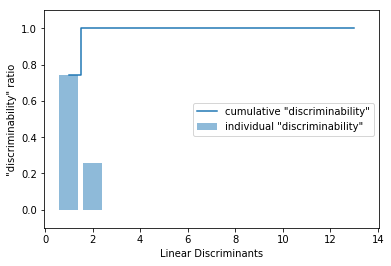

In [13]:
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

In [14]:
# 判別力のある固有ベクトルのみを横に並べて変換行列を作る
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))

In [15]:
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


In [16]:
X_train_lda = X_train_std.dot(w)

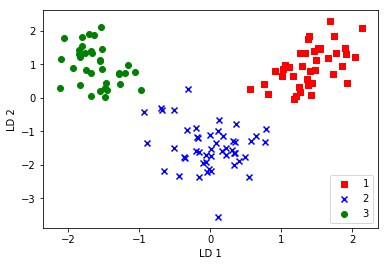

In [17]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0] * (-1), X_train_lda[y_train==l, 1] * (-1), c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

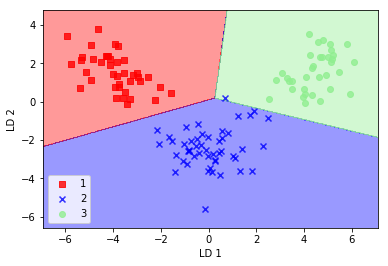

In [20]:
from plot_decision_regions import plot_decision_regions

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

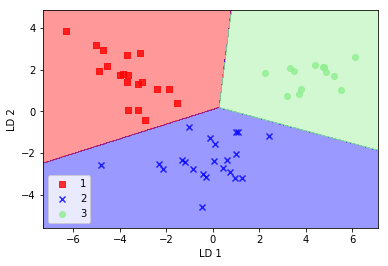

In [21]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()